The purpose of this notebook is to demonstrate how a relatively simple analysis can be run on events generated with metadata queried for the analysis object itself, thus illustrating the building blocks of fully atomatic cross-section comparisons.

### Load a HEPData Record

We can either load a record via the path of a `submission.yaml` file or via a 'Resource Reference'.

#### Load via Path

First, lets confirm where the local submission file is on disk.

In [1]:
%%bash
ls -l /root/software/NUISANCEMC/neutrino_data/data/MicroBooNE/PRD.109.092007/submission-2709091/submission.yaml

-rw-r--r-- 1 root root 5657 Sep 28 11:31 /root/software/NUISANCEMC/neutrino_data/data/MicroBooNE/PRD.109.092007/submission-2709091/submission.yaml


We can try and load this record with the NUISANCE RecordFactory

In [2]:
import pyNUISANCE as pn

rf = pn.RecordFactory()
hepdata_rec = rf.make_record({"type":"hepdata",
    "recordpath":"/root/software/NUISANCEMC/neutrino_data/data/MicroBooNE/PRD.109.092007/submission-2709091/submission.yaml"})

Welcome to JupyROOT 6.30/04


and then we can take a look at what analyses are defined within that record:

In [3]:
print(hepdata_rec.get_analyses())

['cross_section-deltapn', 'cross_section-deltaalpha3dq', 'cross_section-deltaphi3d', 'cross_section-deltapnpar', 'cross_section-deltapnperp', 'cross_section-deltapnperpx', 'cross_section-deltapnperpy', 'cross_section-serialdeltapn_deltaalpha3dq', 'cross_section-serialdeltaalpha3dq_deltapn']


This method is very useful for a tighter debugging loop while building and testing submissions as it removes the need to adhere to a strict filesystem structure on disk or constant reuploading/downloading of submissions to the hepdata sandbox.

#### Load via Resource Reference

A resource reference is of the form `[<type=hepdata>:][<id>][[/]<resource[:<qualifier>]>]` (see [Resource References](https://github.com/NUISANCEMC/HEPData?tab=readme-ov-file#resource-references) for more details).

We need to make sure that the environment variable `NUISANCEDB` is set such that the resource reference can resolve locally without trying to pull the file down from HEPData, because the record has not yet been uploaded to HEPData.

In [4]:
import os

#set the nuisance local store environment variable
os.environ["NUISANCEDB"] = "/root/software/NUISANCEMC/neutrino_data/local_store"
%ls  /root/software/NUISANCEMC/neutrino_data/local_store/INSPIREHEP

1198020@  1343108@  2638628@  2646102@  2709091@  999999@


So we have local copies of these INSPIREHEP Ids, the one for the record of interest is: `2709091`, so we can use the `inspirehep:2709091v1` to reference the record.

This might seem quite clunky, but that is only because we are trying to load a record that we have a local copy of but does not exist in the remote repository yet. For local development, the path-style reference described above is a lot more ergonomic.

In [23]:
hepdata_rec = rf.make_record({"type":"hepdata","recordref":"inspirehep:2709091v1"})
print(hepdata_rec.get_analyses())

['cross_section-deltapn', 'cross_section-deltaalpha3dq', 'cross_section-deltaphi3d', 'cross_section-deltapnpar', 'cross_section-deltapnperp', 'cross_section-deltapnperpx', 'cross_section-deltapnperpy', 'cross_section-serialdeltapn_deltaalpha3dq', 'cross_section-serialdeltaalpha3dq_deltapn']


So you can see it has been loaded successfully and produces the same result!

### Running an Analysis

So now we would like to run an analysis from this record, lets start with the `cross_section-pn` analysis

In [6]:
ana = hepdata_rec.analysis("cross_section-deltapnperpx")

So that loaded successfully. We can query a few things from the high-level analysis interface, but the first thing we need to do is throw some appropriate events.

#### Generating a Prediction

The two main bits of information we need to throw some events are the neutrino probe energy spectrum and species, and the target material. First we will query the flux.

Different generators expect the flux spectrum in a slightly different format: some treat the value of the spectrum within a bin to correspond to the number of neutrinos in that energy range, and some treat it as the number density of neutrinos in that energy range. We can get the flux in either format with a switch, demonstrated below. For a uniformly binned flux, the choice factorises as a normalization and shouldn't matter for event generation.

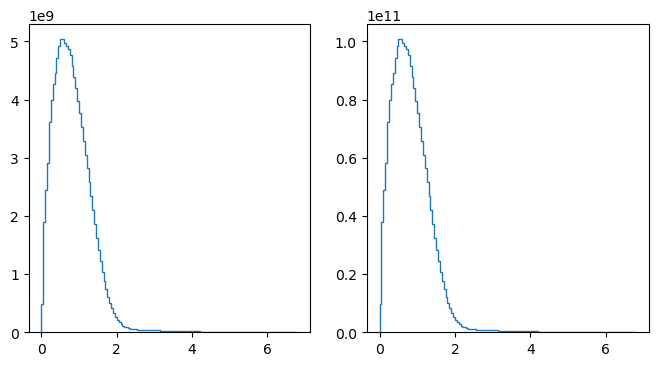

In [7]:
import matplotlib.pyplot as plt

probe_part, probe_flux_count = ana.get_probe_flux(False)
_, probe_flux_count_density = ana.get_probe_flux(True)

fig, axes = plt.subplots(1,2, figsize=(8,4))

probe_flux_count.mpl().hist(histtype="step",plot_axis=axes[0])
probe_flux_count_density.mpl().hist(histtype="step",plot_axis=axes[1])

plt.show()

Most generators expect flux distributions in the form of root histograms, rather than HEPData yaml tables, so lets save both formats to a local file.

In [8]:
pn.convert.ROOT.write_TH1("flux_for_inspirehep_2709091v1.root",
                          "flux_count", probe_flux_count,False,"RECREATE")
pn.convert.ROOT.write_TH1("flux_for_inspirehep_2709091v1.root",
                          "flux_count_density", probe_flux_count_density,False,"UPDATE")

We also need to be able to programtically query the neutrino species that the proble flux corresponds to. In general analyses can have any number of multi-species spectra, but for the vast majority of measurements we only want to use one spectra for one probe particle species.

In [9]:
print(probe_part)

14


We can see that we need to generate muon neutrino events with the above flux distribution.

Next we need to know the target material to generate on. In general the material can be queried as a mass-weighted admixture of elemental components, for most measurements the target is approximated as a single element or a simple element + hydrogen molecule.

In [10]:
[ str(tgt) for tgt in ana.get_target() ]

['{ A = 40, Z = 18, weight_by_mass = 1 }']

So now we can generate some events! For this demo I'm going to use a NEUT helper script that exposes simple options along these lines that we can use, in the future analyses will be able to construct generation prompts that can help you generate the right events for a range of generators. Treat in store.

In [11]:
%%bash
neut-quickstart --help

  Required options:
	-o|--output <filename.hepmc3>  : Output HepMC3 file
	-n|--nevents <numevents>          : Specify the number of events to process or generate.

  Options:
	--neut-card <neut.card>        : NEUT card to specialize
	--neut-param <pname> <val>     : Specify arbitrary NEUT parameters.
	                                 This will override parameters in the base card or set elsewhere 
	                                 in this script.
	                                 This can be used more than once.
	-t|--target <C|O|CH|H2O|Fe>       : Specify the target nucleus/molecule.
	-s|--species <nu[mu,e][,b]>       : Specify the neutrino species.
	-f|--flux <file.root><,histname>  : Throw an event rate according to flux * cross section. 
	                                 Flux histogram should be binned in GeV.
	--uniform <from> <to>          : Throw a uniform event rate as a function of energy in MeV.
	--mono-E <E>                   : Throw a events with energy E in MeV.

	--verbos

In [12]:
%%bash
# only generate if we haven't already
if [ ! -e events_for_inspirehep_2709091v1.hepmc3.gz ]; then
    neut-quickstart -t Ar -s numu \
                -f flux_for_inspirehep_2709091v1.root,flux_count \
                -n 500000 \
                -o events_for_inspirehep_2709091v1.hepmc3.gz
fi

When this is done, we can load up the file

In [13]:
neut_events = pn.EventSource("events_for_inspirehep_2709091v1.hepmc3.gz")
if not neut_events:
    print("Failed to read file")

### Building a Prediction

There are a few methods for building a prediction, more or less manual. The more manual you go, the more you can intervene in the process to do associated truth studies. If you just want to make some plots or get a GoF between your prediction and the measurement, the most automated approach should serve you well.

#### The Automated Way

In [14]:
comparison = ana.process(neut_events)

348.0952259712964


[]

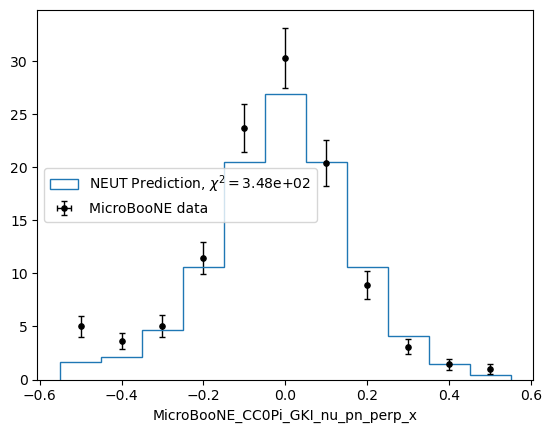

In [15]:
comparison.data[0].mpl().data_hist(label="MicroBooNE data")
comparison.predictions[0].mpl().hist(histtype="step",label=r"NEUT Prediction, $\chi^{2}=$"f"{comparison.likelihood():.3}")
print(comparison.likelihood())
plt.legend()
plt.plot()

##### Double differential

In [24]:
ana2d = hepdata_rec.analysis("cross_section-serialdeltapn_deltaalpha3dq")

In [25]:
comparison = ana2d.process(neut_events)

0.0009649229235920724


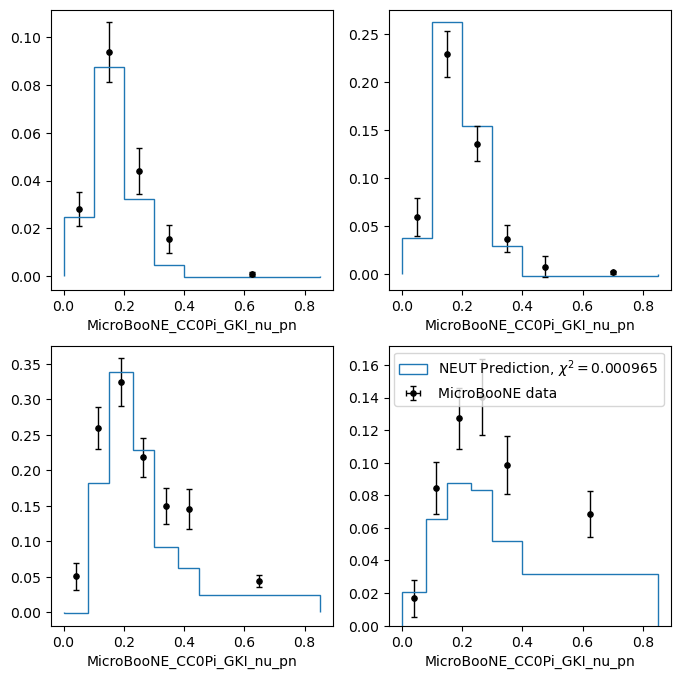

In [26]:
import numpy as np

d2d = comparison.data[0]
p2d = comparison.predictions[0]

fig, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.reshape(1,4).squeeze()

proj_y_bin_centers = np.array(pn.Binning.get_bin_centers1D(proj_y_bins))

for i,y in enumerate(proj_y_bin_centers):
    d2d.slice(1,y).mpl().data_hist(label="MicroBooNE data",plot_axis=axes[i])
    p2d.slice(1,y).mpl().hist(histtype="step",label=r"NEUT Prediction, $\chi^{2}=$"f"{comparison.likelihood():.3}",plot_axis=axes[i])

print(comparison.likelihood())
plt.legend()
plt.show()


#### The Manual Way

The manual way involves getting the selection and projection operators from the analsis and processing the events explicitly, and then applying any scaling explicitly as well.

In [27]:
ins2709091_efg = pn.EventFrameGen(neut_events) \
    .add_int_column(*ana.get_selection())

for proj_name, projf in zip(*ana.get_projections()):
    ins2709091_efg.add_double_column(proj_name,projf)

ef = ins2709091_efg.firstArrow(int(1E6))

We now have an Apache Arrow table, with contains columns corresponding to the selection and projection operators from our analysis. An Arrow table is equivalent to a 'dataframe' in data scientist language, and can in fact be manipulated as a pandas/polars dataframe if you're familiar with those packages.

In [28]:
df = ef.to_pandas()
df

,event.number,weight.cv,process.id,fatx.estimate,MicroBooNE_CC0Pi_GKI_nu_SelectSignal,MicroBooNE_CC0Pi_GKI_nu_pn_perp_x
0,0,1.0,300,0.423712,1,-6.276736e-01
1,1,1.0,300,0.423712,0,1.686979e-01
2,2,1.0,300,0.423712,0,-4.807196e-02
3,3,1.0,200,0.423712,1,-4.375539e-02
4,4,1.0,251,0.423712,0,3.735929e+09
...,...,...,...,...,...,...
499995,499995,1.0,251,0.423712,0,3.735929e+09
499996,499996,1.0,200,0.423712,1,1.598500e-02
499997,499997,1.0,400,0.423712,0,-1.207071e-01
499998,499998,1.0,251,0.423712,0,3.735929e+09


In [29]:
df[df["MicroBooNE_CC0Pi_GKI_nu_SelectSignal"] == 1]

,event.number,weight.cv,process.id,fatx.estimate,MicroBooNE_CC0Pi_GKI_nu_SelectSignal,MicroBooNE_CC0Pi_GKI_nu_pn_perp_x
0,0,1.0,300,0.423712,1,-0.627674
3,3,1.0,200,0.423712,1,-0.043755
5,5,1.0,200,0.423712,1,0.125305
6,6,1.0,200,0.423712,1,0.098793
10,10,1.0,200,0.423712,1,-0.094307
...,...,...,...,...,...,...
499971,499971,1.0,200,0.423712,1,-0.111248
499973,499973,1.0,200,0.423712,1,-0.171182
499986,499986,1.0,200,0.423712,1,0.029371
499994,499994,1.0,200,0.423712,1,0.004601


We can use the data histogram as a 'blueprint' for a prediction histogram, as below:

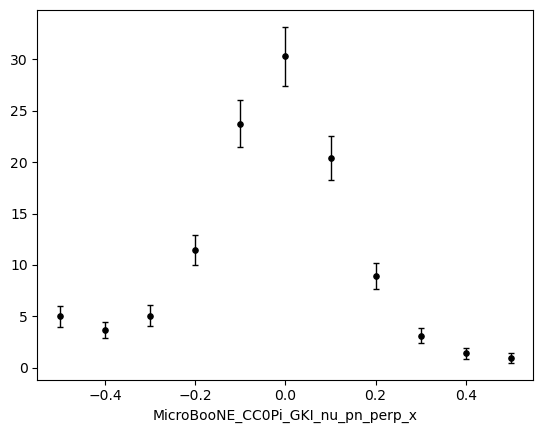

In [30]:
data = ana.get_data()[0]
data.mpl().data_hist()
plt.show()

mc = data.make_HistFrame()

We can then fill the histogram (`HistFrame`) from the table that we made earlier with the slightly clunky `fill_from_Arrow` function family.

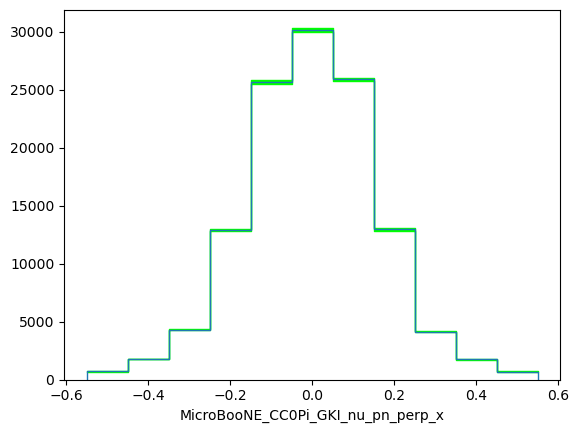

In [31]:
mc = data.make_HistFrame()
mc.fill_from_Arrow_if(ef,ana.get_selection()[0],ana.get_projections()[0])

mc.mpl().hist(histtype="step", errorband_color="#0F0")
plt.show()

We now have a theory prediction in 'true space'. For this particular measurement we then need to smear this prediction to compare to the data, which is published in a regularized space.

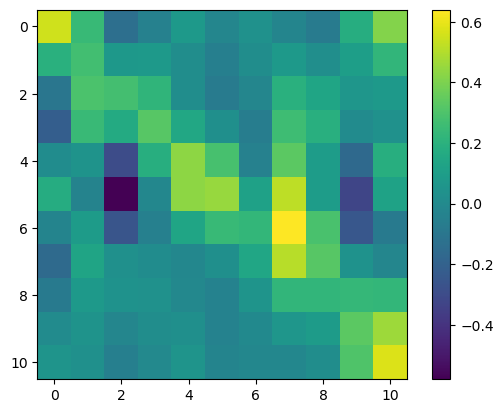

In [32]:
plt.imshow(ana.get_smearing_matrix())
plt.colorbar()
plt.show()

In [33]:
smeared = data.make_HistFrame()
smeared.sumweights = ana.get_smearing_matrix() @ mc.sumweights

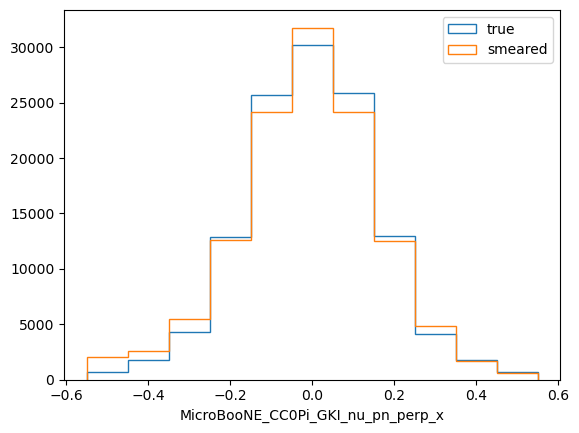

In [34]:
mc.mpl().hist(histtype="step",label="true")
smeared.mpl().hist(histtype="step",label="smeared")
plt.legend()
plt.show()

The final processing that is required before comparing to the data is scaling to the appropriate cross section units. We can ask the analysis object for the relevant scaling information as below: We get 3 bits of information back: the scaling units, an additional overall weight, and whether we need to divide out the bin widths from the histogram values to make a PDF prediction.

In [35]:
str(ana.get_cross_section_scaling())

'{ units = [1e-38 cm2, PerTarget], extra_scale_factor = 1, divide_by_bin_width = true }'

We can get the overall generator normalization from the `EventSource`. We have to be a bit careful here as usually the `EventSource` only knows the generator normalization after it has run over all of the events at least once. Both the building of the Arrow table and the analysis `process` call above loop over the events, so we can trust the normalisation information at this point.

We can pass the unit scaling from the analysis to get the cross section in the correct units:

In [36]:
ni = neut_events.norm_info(ana.get_cross_section_scaling().units)
print(f"norm_info: {{ fatx = {ni.fatx}, sumweights = {ni.sumweights} }}")

norm_info: { fatx = 42.371183910826, sumweights = 500000.0 }


In [37]:
prediction = smeared.finalise(ana.get_cross_section_scaling().divide_by_bin_width)
prediction.values = prediction.values * ni.fatx_per_sumweights()

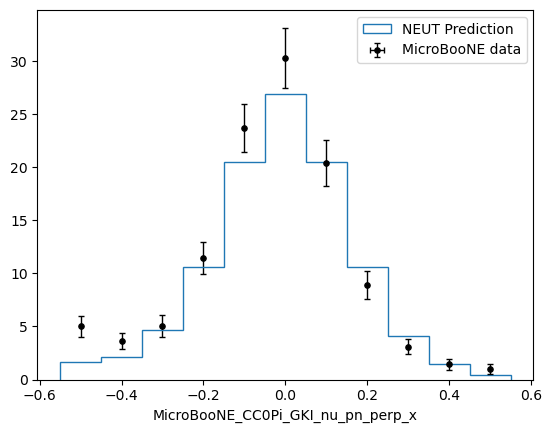

In [38]:
prediction.mpl().hist(histtype="step",label="NEUT Prediction")
data.mpl().data_hist(label="MicroBooNE data")
plt.legend()
plt.show()

The very final part of the puzzle is the likelihood, which we can manually calculate with the covariance matrix from the analysis object.

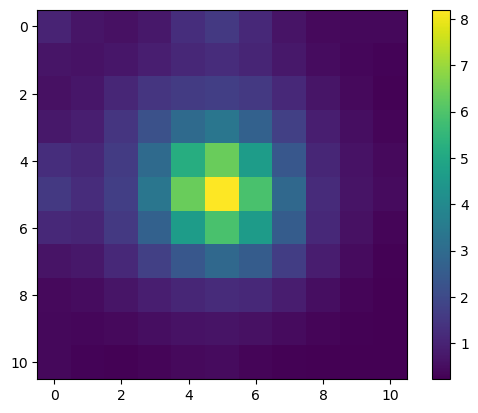

In [39]:
plt.imshow(ana.get_covariance_matrix())
plt.colorbar()
plt.show()

In [40]:
pred_minus_data = (prediction.values - data.values)
chi2 = pred_minus_data.T @ ana.get_covariance_matrix() @ pred_minus_data
print(chi2)

[[348.09522597]]


which matches what we calculated from the automated comparison earlier!